In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url

## Acquire

In [54]:
query = """
SELECT  bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet AS sqft, taxvaluedollarcnt AS tax_value, fips,taxamount 
FROM properties_2017
JOIN predictions_2017 USING (id)
JOIN propertylandusetype USING (propertylandusetypeid)
WHERE (transactiondate  >='2017-05-01' AND transactiondate <= '2017-06-30') AND propertylandusetypeid = '261'
AND taxvaluedollarcnt <= 1000000;
"""
df = pd.read_sql(query, get_db_url("zillow"))
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [55]:
df.dtypes

bathroomcnt    float64
bedroomcnt     float64
sqft           float64
tax_value      float64
fips           float64
taxamount      float64
dtype: object

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14860 non-null float64
bedroomcnt     14860 non-null float64
sqft           14828 non-null float64
tax_value      14860 non-null float64
fips           14860 non-null float64
taxamount      14828 non-null float64
dtypes: float64(6)
memory usage: 696.7 KB


## Prep

In [57]:
df = df.dropna()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14802 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14802 non-null float64
bedroomcnt     14802 non-null float64
sqft           14802 non-null float64
tax_value      14802 non-null float64
fips           14802 non-null float64
taxamount      14802 non-null float64
dtypes: float64(6)
memory usage: 809.5 KB


In [59]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

In [60]:
df.shape

(14802, 6)

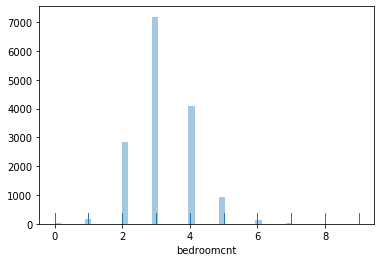

In [9]:
sns.distplot(df['bedroomcnt'],kde=False,rug=True)

In [10]:
df.bathroomcnt.sort_values()

9958     0.0
9739     0.0
12246    0.0
11736    0.0
10404    0.0
        ... 
6116     7.0
811      7.0
10122    7.0
10280    7.0
1406     7.0
Name: bathroomcnt, Length: 15420, dtype: float64

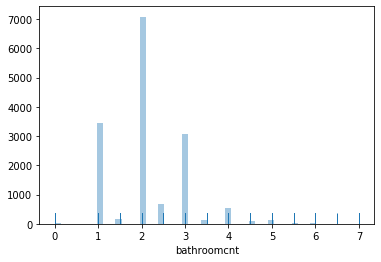

In [11]:
sns.distplot(df['bathroomcnt'],kde=False,rug=True)

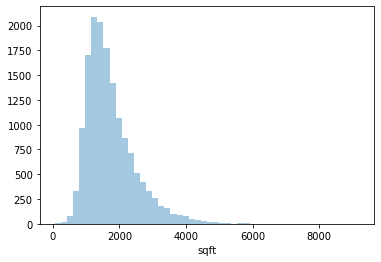

In [12]:
sns.distplot(df['sqft'],kde=False,rug=False)

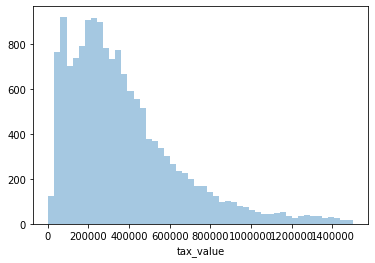

In [13]:
sns.distplot(df['tax_value'],kde=False,rug=False)

In [14]:
import split_scale

In [15]:
train, test = split_scale.split_my_data(df)

In [16]:
train.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
8805,3.0,4.0,3326.0,625329.0,6037.0,7665.88
767,3.0,5.0,2593.0,721000.0,6037.0,8880.41
5095,1.0,2.0,1190.0,377968.0,6037.0,4767.01
15083,1.0,3.0,960.0,154490.0,6037.0,1956.84
7602,2.5,3.0,2403.0,457731.0,6059.0,5957.28


In [17]:
train.bathroomcnt.mean()

2.12552691309987

In [18]:
train.bedroomcnt.mean()

3.2091439688715955

In [19]:
train.sqft.mean()

1741.3125810635538

In [20]:
print(train.shape); print(test.shape)

(12336, 6)
(3084, 6)


In [21]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [22]:
train.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
8805,0.999868,0.862305,2.104914,0.917557,-0.429469,0.952697
767,0.999868,1.952650,1.131282,1.265637,-0.429469,1.335502
5095,-1.286921,-1.318383,-0.732299,0.017584,-0.429469,0.039010


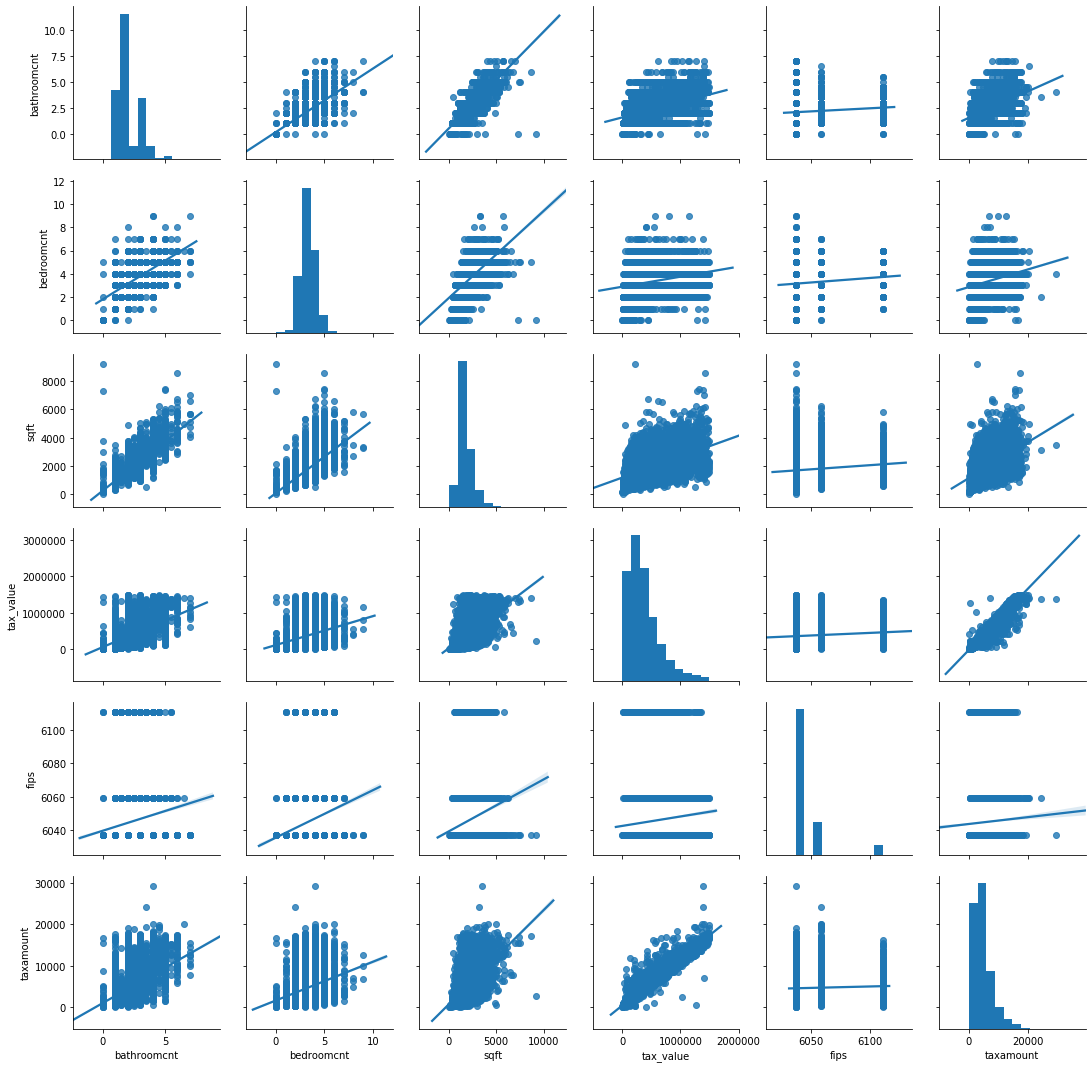

In [23]:
sns.pairplot(df, kind="reg")
plt.show()

(0, 4)

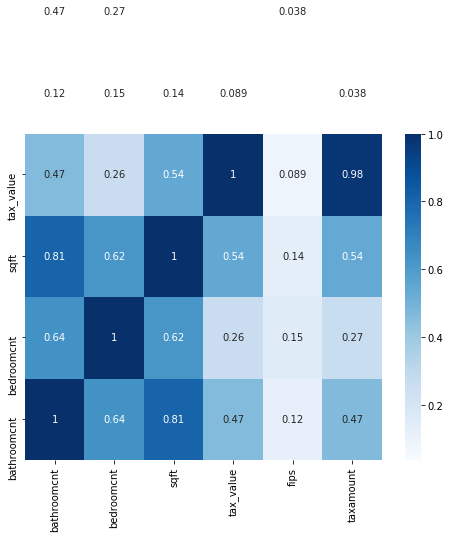

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

## Exploration

$H_0$: There is a linear relationship between sqft and tax_value.

$H_a$: There is no linear relationship between sqft and tax_value.

In [25]:
from math import sqrt
from scipy import stats

In [26]:
alpha = 0.01
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

(0.5431429443884696, 0.0)

In [27]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


In [28]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.tax_value)
r, p

(0.4653847908656674, 0.0)

In [29]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.tax_value)
r, p

(0.26118124621628624, 1.6110975633351353e-191)

In [30]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.sqft)
r, p

(0.6223677302852362, 0.0)

In [31]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.bathroomcnt)
r, p

(0.6375097332544661, 0.0)

In [32]:
predictions = pd.DataFrame({
    'actual_tax_value': train.tax_value
})
predictions.head()

,actual_tax_value
8805,0.917557
767,1.265637
5095,0.017584
15083,-0.795495
7602,0.307786


In [33]:
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")
import split_scale

In [34]:
X = train[['bathroomcnt','bedroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed_lm'] = lm.predict(X)

In [35]:
predictions.head(3)

,actual_tax_value,bath&bed_lm
8805,0.917557,0.451872
767,1.265637,0.386651
5095,0.017584,-0.569127


In [36]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed&sqft_lm'] = lm.predict(X)

In [37]:
predictions.head(3)

,actual_tax_value,bath&bed_lm,bath&bed&sqft_lm
8805,0.917557,0.451872,1.115723
767,1.265637,0.386651,0.431239
5095,0.017584,-0.569127,-0.360603


In [38]:
predictions['baseline'] = predictions.actual_tax_value.mean()
predictions.head(3)

,actual_tax_value,bath&bed_lm,bath&bed&sqft_lm,baseline
8805,0.917557,0.451872,1.115723,5.185721e-17
767,1.265637,0.386651,0.431239,5.185721e-17
5095,0.017584,-0.569127,-0.360603,5.185721e-17


In [39]:
X = train[['bathroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath_lm'] = lm.predict(X)

In [40]:
X = train[['bedroomcnt',]]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [41]:
X = train[['sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['sqft_lm'] = lm.predict(X)

In [42]:
X = train[['bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [43]:
X = train[['bathroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&sqft_lm'] = lm.predict(X)

In [44]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_tax_value, col))

actual_tax_value    0.000000
bath&bed_lm         0.781293
bath&bed&sqft_lm    0.688995
baseline            1.000000
bath_lm             0.783417
bed&sqft_lm         0.695355
sqft_lm             0.704996
bath&sqft_lm        0.702752
dtype: float64

In [45]:
def select_rfe(X, y, k):
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, k)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [46]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
k = 2
select_rfe(X, y, k)

Index(['bedroomcnt', 'sqft'], dtype='object')

In [47]:
def select_kbest(X, y, k):
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k)
    kbest.fit(X, y)
    return X.columns[kbest.get_support()]

In [48]:
select_kbest(X, y, k)

Index(['bathroomcnt', 'sqft'], dtype='object')

In [49]:
# 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tip using total_bill.
from statsmodels.formula.api import ols
model = ols('tax_value ~ bathroomcnt', df).fit()
df['yhat'] = model.predict(df.bathroomcnt)

In [50]:
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount,yhat
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82,355542.484777
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55,501684.711096
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31,355542.484777
3,2.0,2.0,1619.0,340000.0,6037.0,4206.15,355542.484777
4,2.0,4.0,1721.0,629951.0,6037.0,6861.51,355542.484777


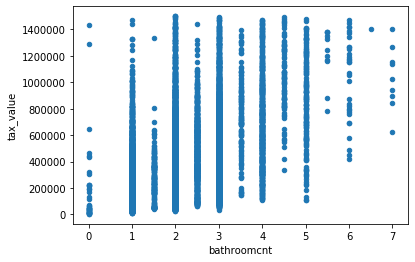

In [51]:
df.plot.scatter(y='tax_value', x='bathroomcnt')

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tax_value   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4224.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:39:12   Log-Likelihood:            -2.1319e+05
No. Observations:               15420   AIC:                         4.264e+05
Df Residuals:                   15418   BIC:                         4.264e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6.326e+04   5162.810     12.253      0.000    5.31e+04    7.34e+04
bathroomcnt  1.461e+05   2248.733     64.989      0.000    1.42e+05    1.51e+05
==============================================================================
Omnibus:                     2880.268   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5735.151
Skew:                           1.129   Prob(JB):                         0.00
Kurtosis:                       4.957   Cond. No.                         7.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
pwd

'/Users/wenliangsun/codeup-data-science/zillow_project'